# Mini-project n° 2– Conditional VAEs
#### Groupe ?? : Laurié Romain, Richaume Julien, Cargnello Romain, Catalogna Lise

L'objectif de ce projet est de définir et d'entrainer un CVAE (Auto-Encoder Conditionnel Variationnel). 

Premièrement, nous installons toutes les librairies nécéssaires à ce projet.

In [25]:
import random
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from IPython.display import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Dataset FashionMNIST

On télécharge les éléments du jeu de données FashionMNIST qui vont nous servir à mettre en place notre CVAE.

Fashion-MNIST est un jeu de données composé d'images d'articles de Zalando.

In [3]:
batch_size = 128

transform = transforms.Compose([transforms.ToTensor()])

# Charger le jeu <de données Fashion-MNIST
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Création des échantillons test et train
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
print(f"Taille de l'échantillon d'entrainement : {len(train_dataset)}")
print(f"Taille de l'échantillon de test : {len(test_dataset)}")

Taille de l'échantillon d'entrainement : 60000
Taille de l'échantillon de test : 10000


Ce jeu de données est composé d'un ensemble d'apprentissage de 60 000 exemples et d'un ensemble de test de 10 000 exemples.

Chaque exemple est une image en niveaux de gris de 28x28, associée à une étiquette parmi 10 classes.
Nous associons dans le code ci-dessous la catégorie de vêtements à laquelle est associée chaque classe.

In [12]:
noms_classes = {
    0: "T-shirt/haut",
    1: "Pantalon",
    2: "Pull-over",
    3: "Robe",
    4: "Manteau",
    5: "Sandale",
    6: "Chemise",
    7: "Baskets",
    8: "Sac",
    9: "Bottines"
}


Nous affichons ci-dessous un exemple de 9 élèments tirés aléatoirement, provenant de l'échantillon d'entrainement et de leur label associé.

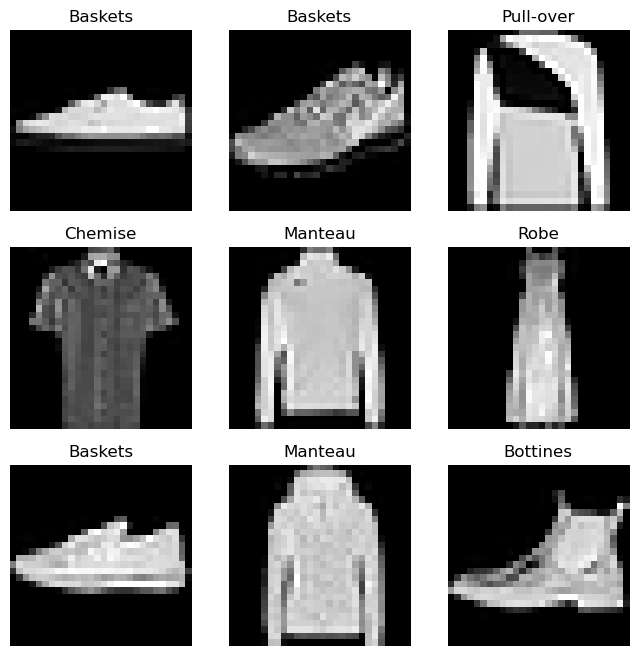

In [15]:
def plot_images(img_dataset):

    #Grille 3*3 pour permettre l'affichage de 9 images
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
      
    for i in range(1, cols * rows + 1):
        random_idx = torch.randint(len(img_dataset), size=(1,)).item()  
        img, label = img_dataset[random_idx]  #récupération de l'image et de son label associé
        figure.add_subplot(rows, cols, i)  
        plt.title(noms_classes[label]) 
        plt.axis("off")  
        plt.imshow(img.squeeze(), cmap="gray") 
    
    plt.show()  

plot_images(train_dataset)

## Mise en place d'un modèle CVAE : 

### Définition : 
On met en place ici un modèle VAE Conditionnel. C'est un modèle où l'encodage latent dépend des images d'entrée mais également des labels associés à chaque image. L'objectif de ce modèle est donc de générer des images en fonction d'une étiquette de données spécifique.

Un CVAE (Conditional Variational Autoencoder) est un modèle génératif qui apprend à produire des données conditionnées sur des informations spécifiques, comme des labels ou des attributs. Il encode les données d'entrée et les conditions dans un espace latent compact en produisant les paramètres d'une distribution gaussienne conditionnelle (moyenne et variance). En phase de génération, un échantillon est tiré de cette distribution, combiné avec les informations conditionnelles, et passé à un décodeur qui reconstruit les données ou en génère de nouvelles respectant les conditions

Ci-dessous, il est possible de visualiser un schéma de CVAE. 

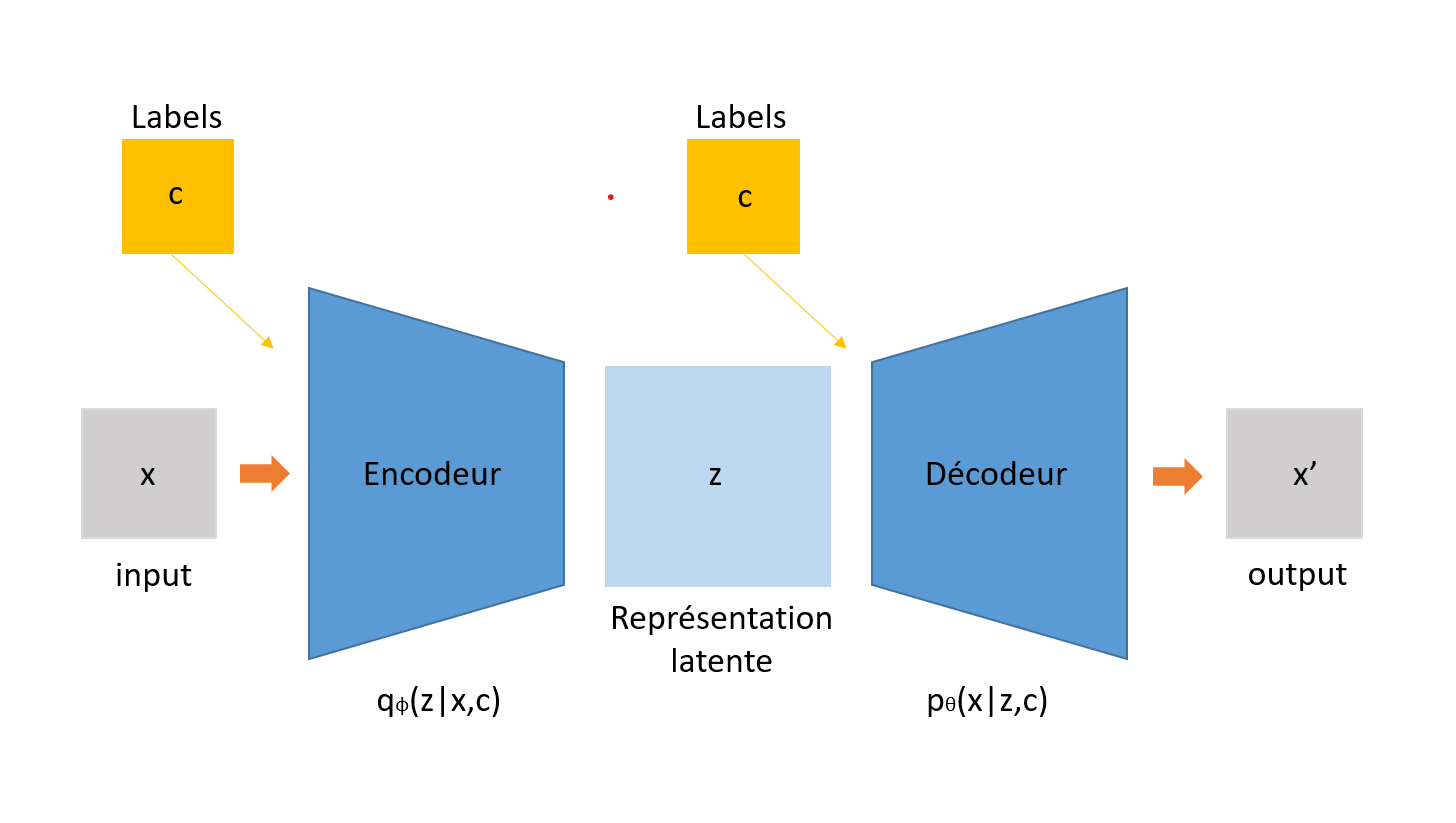

In [34]:
img_path = 'C:/Users/lisec/OneDrive/Documents/cours/5A/HDDL/HDDL/Mini_Projet2/CVAE.png'
Image(img_path, width=700)

La différence entre le VAE Conditionnel (CVAE) et le VAE simple est que l'on donne en entrée de l'encodeur et du décodeur du CVAE, un label pour lui donner l'information de ce qu'il a à produire. Ainsi, en ayant cette information, il peut se concentrer sur d'autres informations/aspects des données en entrée (la largeur de l'image, la densité de la coloration, etc).

Les images servent de modèles sur lesquels le décodeur peut se baser lors sa prédiction et les labels permettent ainsi de guider la prédiction vers un certain type d'image. 

Par exemple pour un VAE, on met en entrée de l'encodeur une image. Le décodeur doit donc reconnaitre cette image et tenter de la reproduire. Pour un CVAE, en plus de l'image donnée à l'encodeur, on fournit aussi le label de cette image (la catégorie à laquelle elle appartient) comme information conditionnelle au décodeur. Cela permet au décodeur 
de savoir d'avance qu'il doit reconstruire une image du label précisé, ce qui lui laisse plus de capacité pour se concentrer sur d'autres caractéristiques de l'image.

### Choix de l'architecture : 

Pour le choix de l'architecture du modèle, nous avons choisi d'utiliser des couches convolutionnelles. En effet, celles-ci sont les plus adéquates pour l'analyse 
d'image, elles ont une approche locale et analysent les images zone par zone pour avoir des résultats précis. 
Les couches de convolution analyse graduellement l'image. La première couche analyse les petits motifs de l'image et les suivantes analysent les motifs de 
plus en plus gros.
 

Voici l'architecture du modèle CVAE mis en place: 

- **The Encoder:** 
    - Convolution layer with 32 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Convolution layer with 64 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Convolution layer with 128 filters, a kernel size of 3, stride 2 and padding 1.
    - Batchnorm layer keeping the same number of features
    - ReLU layer


- **The Latent Space:** The encoder outputs are converted into the mean vector $\mu$ and logarithm of the variance vector $\log\sigma^2$, via two paraller fully connected layers. We will need to define:
    - A FC layer to map the output of the encoder $E(x)$ to the mean vector $\mu(x)$.
    - A FC layer to map the output of the encoder $E(x)$ to the log-variance vector $\log\sigma^2(x)$.
    - A FC layer to map the sampled hidden stacte $z(x)\sim\mathcal{N}(\mu(x),Diag(\sigma(x)))$ to the decoder input.


- **The Decoder.** 
    - Deconvolution layer with 64 filters, a kernel size of 3, stride 2 and padding 1.
    - BatchNorm laayer keeping the same number of features
    - ReLu activation
    - Deconvolution layer with 32 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Deconvolution layer with 1 filter, a kernel size of 4, stride 2 and padding 1.
    - Sigmoid layer

In [16]:
class ConvCVAE(nn.Module):
    def __init__(self, latent_dim=10, num_classes=10):
        super(ConvCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # taille Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # taille Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # taille Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

    
        self.fc_mu = nn.Linear(128 * 4 * 4 + num_classes, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4 + num_classes, latent_dim)
        self.fc_decode = nn.Linear(latent_dim + num_classes, 128 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # taille Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # taille Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # taille Output: (1, 28, 28)
            nn.Sigmoid()
        )

    def encode(self, x, labels):
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4)  # Flatten des couches de convolutions

        # Concaténation des labels à la sortie de l'encodeur
        x = torch.cat((x, labels), dim=1)
        mu = self.fc_mu(x) 
        logvar = self.fc_logvar(x)
        return mu, logvar

    # Gnération d'échantillon à partir de la distribution gaussienne par une méthode de reparamétrisation.
    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):
        z = torch.cat((z, labels), dim=1)
        z = z.to(device)
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.sample(mu, logvar)
        return self.decode(z, labels), mu, logvar

La fonction ci-dessous va nous permettre de transformer les labels des données au format one-hot

In [17]:
#Récupération au format one-hot encoding des labels
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)

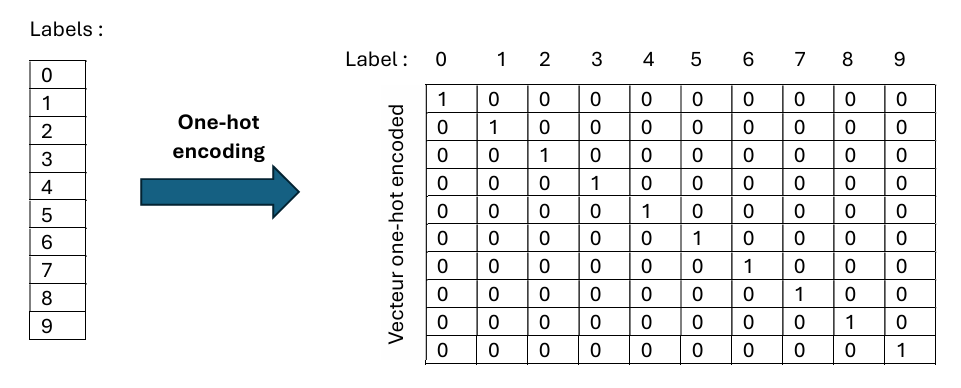

In [27]:
img_path = 'C:/Users/lisec/OneDrive/Documents/cours/5A/HDDL/HDDL/Mini_Projet2/one-hot.png'
Image(img_path)

### Fonction de perte

#### Choix de la fonction de perte : 

Voici la formule de la fonction de perte que nous avons décidé d'utiliser : 

\begin{align*}
\text{Loss} &= \text{BCE} + \beta \cdot \text{KLD} \\
\newline
\text{où } \quad \text{BCE} &= -\sum_{i} \left( x_i \log(\hat{x}_i) + (1 - x_i) \log(1 - \hat{x}_i) \right) \\
\text{KLD} &= -\frac{1}{2} \sum_{j} \left( 1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2 \right)
\end{align*}


Elle est composée de deux termes : la **cross entropy binaire** et la **divergence de Kullback-Leibler**.

- La première partie de la fonction de perte correspond à l'erreur de reconstruction, elle permet donc d'évaluer notre modèle et d'évaluer la fidélité des nouveaux données aux vraies données. Pour obtenir un modèle qui reconstruit bien, il faut minimiser la cross entropy entre la distribution de probabilité prédite et la réelle.

- La divergence de Kullback-Leibler est un facteur de régularisation. Il permet de mesurer la divergence entre deux distributions de probabilité et indique la proportion d'information perdue en utilisant une distribution pour représenter l'autre. Ce facteur permet de gérer la qualité de représentation des données dans l'espace latent qui a un impact direct sur la qualité de génération de nouveaux échantillons de données. Il implique aussi à l'espace latent d'être distribué normalement autour de 0.

- Le facteur β est un coefficient de pondération pour ajuster l'importance de la régularisation (terme KLD) par rapport à la reconstruction (terme cross-entropy). Plus β est grand, plus l'espace latent est proche d'une gaussienne centrée réduite. 



In [29]:
def loss_function(recon_x, x, mu, logvar, beta):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum') ## cross-entropy binaire
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) ## terme de divergence de KL
    return BCE + beta * KLD, BCE, KLD

### Entrainement d'un modèle CVAE

Tout d'abord nous décidons d'entrainer un modèle avec des hyperparamètres choisis aléatoirement. Ce modèle servira de base, que l'on cherchera dans la suite à optimiser afin d'améliorer les prédictions. A la fin de nos analyses, nous comparerons ce modèle avec le modèle optimisé obtenu.

In [30]:
# Hyperparameters
batch_size = 128
latent_dim = 2
learning_rate = 1e-3
epochs = 15
beta = 2  

# Initialize the CVAE model and the Adam optimizer
cvae1 = ConvCVAE(latent_dim=latent_dim, num_classes=10)  # Notez l'ajout de num_classes
cvae1.to(device)
optimizer = optim.Adam(cvae1.parameters(), lr=learning_rate)
# Training loop
for epoch in range(1, epochs + 1):
    cvae1.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize the cumulative loss for the current epoch

    # Iterate through the batches of training data
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)  # Move the input data to the GPU (if available)

        # Convert labels to one-hot encoding
        one_hot_labels = one_hot(labels, class_size=10).to(device)  # Assurez-vous que cela soit sur le bon device

        # Zero the gradients for this batch
        optimizer.zero_grad()

        # Forward pass through the model (passer les étiquettes aussi)
        recon_batch, mu, logvar = cvae1(data, one_hot_labels)

        # Compute the loss for this batch
        loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]

        # Backpropagate the loss and update model parameters
        loss.backward()
        optimizer.step()

        # Accumulate the batch loss
        running_loss += loss.item()

    # Compute and print the average loss for this epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')


Epoch 1, Training loss: 275.8099
Epoch 2, Training loss: 261.9151
Epoch 3, Training loss: 260.4184
Epoch 4, Training loss: 259.5229
Epoch 5, Training loss: 258.8401
Epoch 6, Training loss: 258.3324
Epoch 7, Training loss: 257.8760
Epoch 8, Training loss: 257.5141
Epoch 9, Training loss: 257.2182
Epoch 10, Training loss: 256.9570
Epoch 11, Training loss: 256.7277
Epoch 12, Training loss: 256.5720
Epoch 13, Training loss: 256.3590
Epoch 14, Training loss: 256.1362
Epoch 15, Training loss: 255.9237


Après 15 epochs, la fonction de perte atteint la valeur de 255,9237 sur l'échantillon de données d'entrainement. La valeur de la fonction de perte n'est pas ici optimisée, elle ne converge pas car on n'a toujours pas atteint de pallier.

### Evaluation du modèle sur l'échantillon de test

Afin de quantifier la reconstruction des données grace au modèle CVAE construit précédemment et d'évaluer par la suite les hyper-paramètres utilisés, nous affichons la MSE et la fonction de test de l'échantillon de test.

In [36]:
cvae1.eval()

with torch.no_grad():
    test_loss, test_mse = 0.0, 0.0
    for data, labels in test_loader:
        data = data.to(device)
        one_hot_labels = one_hot(labels, class_size=10).to(device)
        
        recon_batch, mu, logvar = cvae1(data, one_hot_labels)
        loss, _, _ = loss_function(recon_batch, data, mu, logvar, beta=beta)
        mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
        
        test_loss += loss.item()
        test_mse += mse

    test_loss /= len(test_loader.dataset)
    test_mse /= len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}, Test MSE: {test_mse:.4f}")


Test Loss: 257.5690, Test MSE: 0.0002


Ces valeurs nous permettrons par la suite de comparer les différents modèles.

### Visualisation des résultats obtenus

 #### Reconstruction d'images

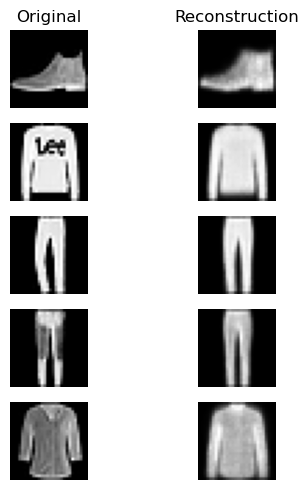

In [37]:
def image_comparison(original_images, reconstructions, n_images=5):

    fig, ax = plt.subplots(n_images, 2, figsize=(5, 5))

    for i in range(n_images):
        # Plot of original images
        ax[i, 0].imshow(original_images[i], cmap='gray')
        ax[i, 0].axis('off')
        ax[i, 0].set_xlabel("0")
        ax[0, 0].set_title('Original')

        # Plot of reconstructed images
        ax[i, 1].imshow(reconstructions[i], cmap='gray')
        ax[i, 1].axis('off')
        ax[i, 1].set_xlabel("1")
        ax[0, 1].set_title('Reconstruction')

    
    plt.tight_layout()
    plt.show()

# Récupération d'images et de leur label dans le dataset
random_images, labels = next(iter(test_loader))  

#Conversion des labels
one_hot_labels = one_hot(labels, class_size=10).to(device) 

# Récupération des images reconstruites correspondantes
recons, _, _ = cvae1(random_images.to(device), one_hot_labels)  


random_images = random_images.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()


image_comparison(random_images, recons)


Le modèle CVAE construit précédemment nous permet d'obtenir les résultats précédents. Il tente ici de reproduire à l'identique les données d'entrée. La qualité de reconstruction du modèle est ici évaluée. 

On constate que  les vêtements produits sont reconnaissables. Cependant, les images sont un peu flous. 

 #### Génération de nouvelles données

Génération de 5 échantillons par classe.

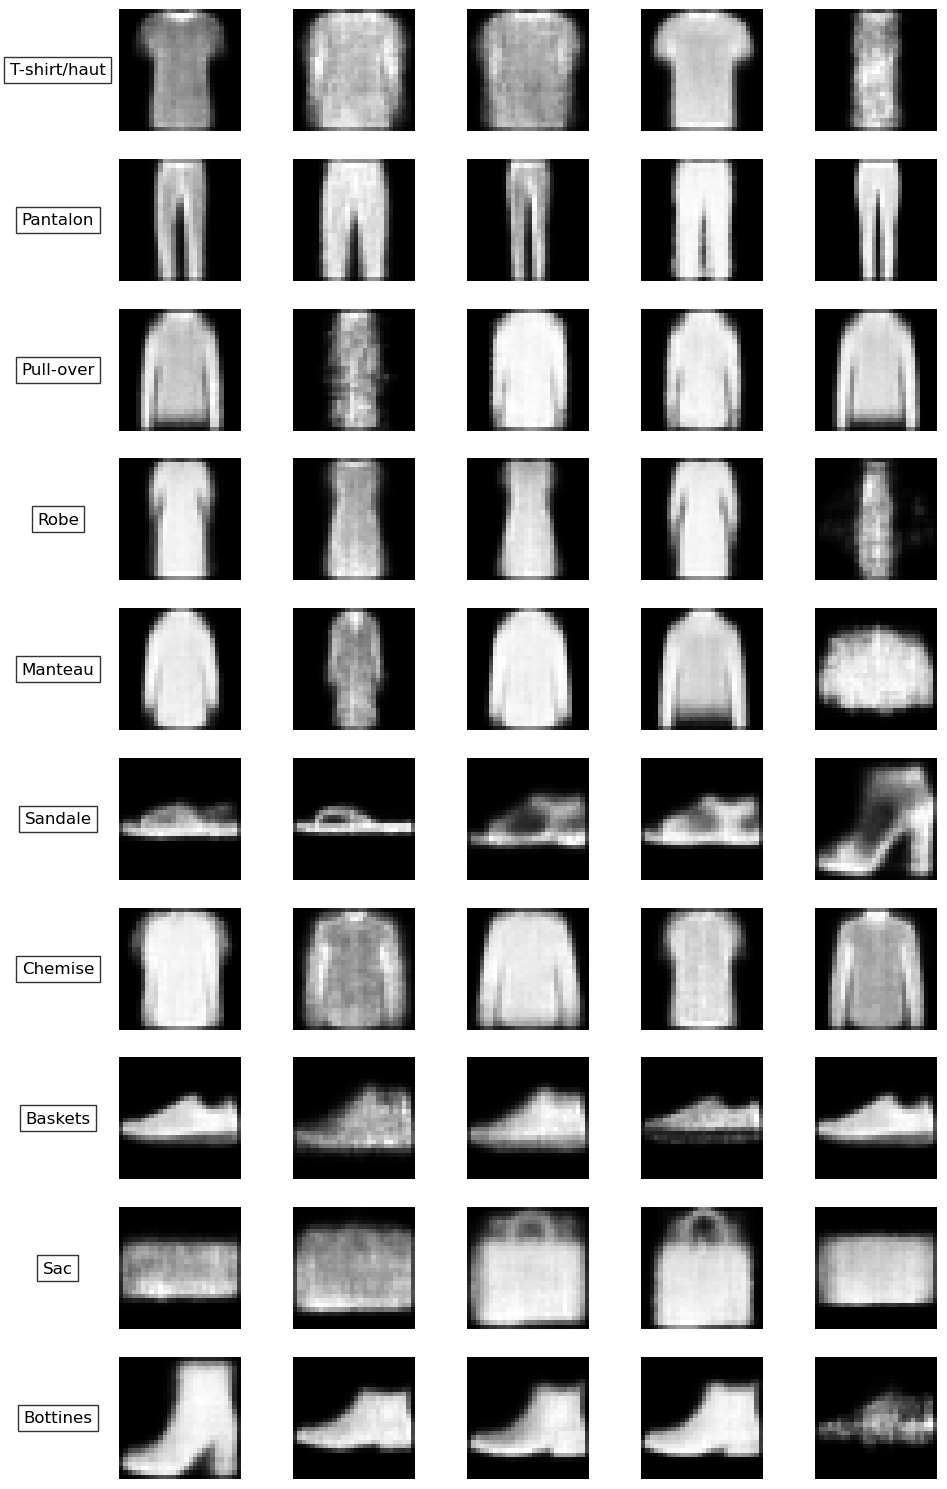

In [39]:
cvae1.eval() #modèle en mode évaluation

num_classes = 10 
num_samples_per_class = 5 #nombre d'exemples par classe affichés

#Fonction pour générer et afficher des échantillons pour chaque classe
def generate_samples_per_class(model, num_classes, num_samples):
    samples = []
    for class_label in range(num_classes):
        class_samples = []
        for _ in range(num_samples):
         
            y = torch.tensor([class_label]).to(torch.long)
            y = torch.nn.functional.one_hot(y, num_classes).float()

            z = torch.randn(1, model.latent_dim) 
            
            #Passer z et y dans le décodeur
            with torch.no_grad():
                generated_image = model.decode(z, y)
                
            class_samples.append(generated_image.squeeze().cpu())
            
        samples.append(class_samples)
        
    return samples


#Générer les échantillons
samples = generate_samples_per_class(cvae1, num_classes, num_samples_per_class)


fig, axs = plt.subplots(num_classes, num_samples_per_class, figsize=(10, 15))

for class_label in range(num_classes):
    for sample_idx in range(num_samples_per_class):
        axs[class_label, sample_idx].imshow(samples[class_label][sample_idx], cmap="gray")
        axs[class_label, sample_idx].axis("off")
    
    axs[class_label, 0].text(-0.5, 0.5, noms_classes[class_label], 
                             rotation=0, size=12, ha="center", va="center",
                             bbox=dict(facecolor='white', alpha=0.8),
                             transform=axs[class_label, 0].transAxes)

plt.tight_layout(h_pad=2)
plt.show()

### Choix des hyperparamètres
Maintenant que nous avons des premiers résultats, nous nous intéressons aux choix des hyperparamètres pour tenter d'améliorer notre modèle.

#### Définition des hyperparamètres : 

Dans les hyper-paramètres du modèle, on décide d'optimiser uniquement le poids de régularisation (facteur β) et la dimension latente. Les hyper-paramètres de la taille du batch et du learning rate n'ont pas une grande influence donc on les prend arbitrairement à eps = 10-3 et taille du batch=128. 

L'optimisation du facteur β permet de trouver un compromis optimal de résultat, garantissant à la fois une reconstruction fidèle des données et une structure latente bien organisée.

La dimension latente détermine la capacité du modèle à capturer les informations pertinentes des données dans un espace de plus faible dimension.

La taille du batch influence en grande partie sur la stabilité de l'optimisation et la rapidité des calculs mais son impact n'a pas une grande influence sur les performences du modèle final. 

Le taux d'apprentissage détermine la vitesse à laquelle le modèle converge vers un minimum local. Il est donc important de bien le choisir, un ordre de grandeur entre 10-3 et 10-4 est généralement efficace. Optimiser ce paramètres n'est donc pas nécessaire dans un premier temps.

Le nombre d'époques détermine combien de fois le modèle parcourt l'ensemble des données d'entraînement. Ce paramètre permet d'assurer une bonne convergence du modèle 
sans provoquer de surapprentissage. 

#### Visualisation de l'espace latent en fonction de la variable β

On décide de visualiser la représentation de l'espace latent et la génération d'échantillons correspondants avec différentes valeurs de beta,donc différents poids de la KLD dans notre fonction de perte.
Cela nous permettrait de juger quel beta nous donne la meilleur génération, même si cela restera à nuancer avec la qualité de reconstruction.

Plusieurs paramètres influent sur cette représentation latente : 
- La valeur de β : Si β est trop faible, le modèle privilégie la reconstruction sur la régularisation (KLD), ce qui peut entraîner un chevauchement des classes.
- La dimension de l'espace latent : l'espace latent doit résumer les données de manière compacte et en tirer les propriétés essentielles. Il doit etre de faible dimension pour gérer des données simples, et pour des données plus complexes il doit capturer des nuances plus importantes donc doit etre de plus grande dimension.


Training VAE with beta = 0.1
Epoch 1: Average Loss: 248.6896, BCE: 245.7051, KLD: 29.8454
Epoch 2: Average Loss: 227.4352, BCE: 224.4395, KLD: 29.9572
Epoch 3: Average Loss: 224.8744, BCE: 221.8922, KLD: 29.8220
Epoch 4: Average Loss: 223.2871, BCE: 220.3196, KLD: 29.6743
Epoch 5: Average Loss: 222.4079, BCE: 219.4535, KLD: 29.5437
Epoch 6: Average Loss: 221.6743, BCE: 218.7270, KLD: 29.4731
Epoch 7: Average Loss: 221.1461, BCE: 218.2010, KLD: 29.4508
Epoch 8: Average Loss: 220.6852, BCE: 217.7466, KLD: 29.3862
Epoch 9: Average Loss: 220.2993, BCE: 217.3662, KLD: 29.3317
Epoch 10: Average Loss: 220.0006, BCE: 217.0707, KLD: 29.2992
Epoch 11: Average Loss: 219.6628, BCE: 216.7370, KLD: 29.2580
Epoch 12: Average Loss: 219.4389, BCE: 216.5123, KLD: 29.2662
Epoch 13: Average Loss: 219.3262, BCE: 216.4031, KLD: 29.2315
Epoch 14: Average Loss: 219.0100, BCE: 216.0917, KLD: 29.1828
Epoch 15: Average Loss: 218.8098, BCE: 215.8929, KLD: 29.1698
Epoch 16: Average Loss: 218.7619, BCE: 215.8503, 

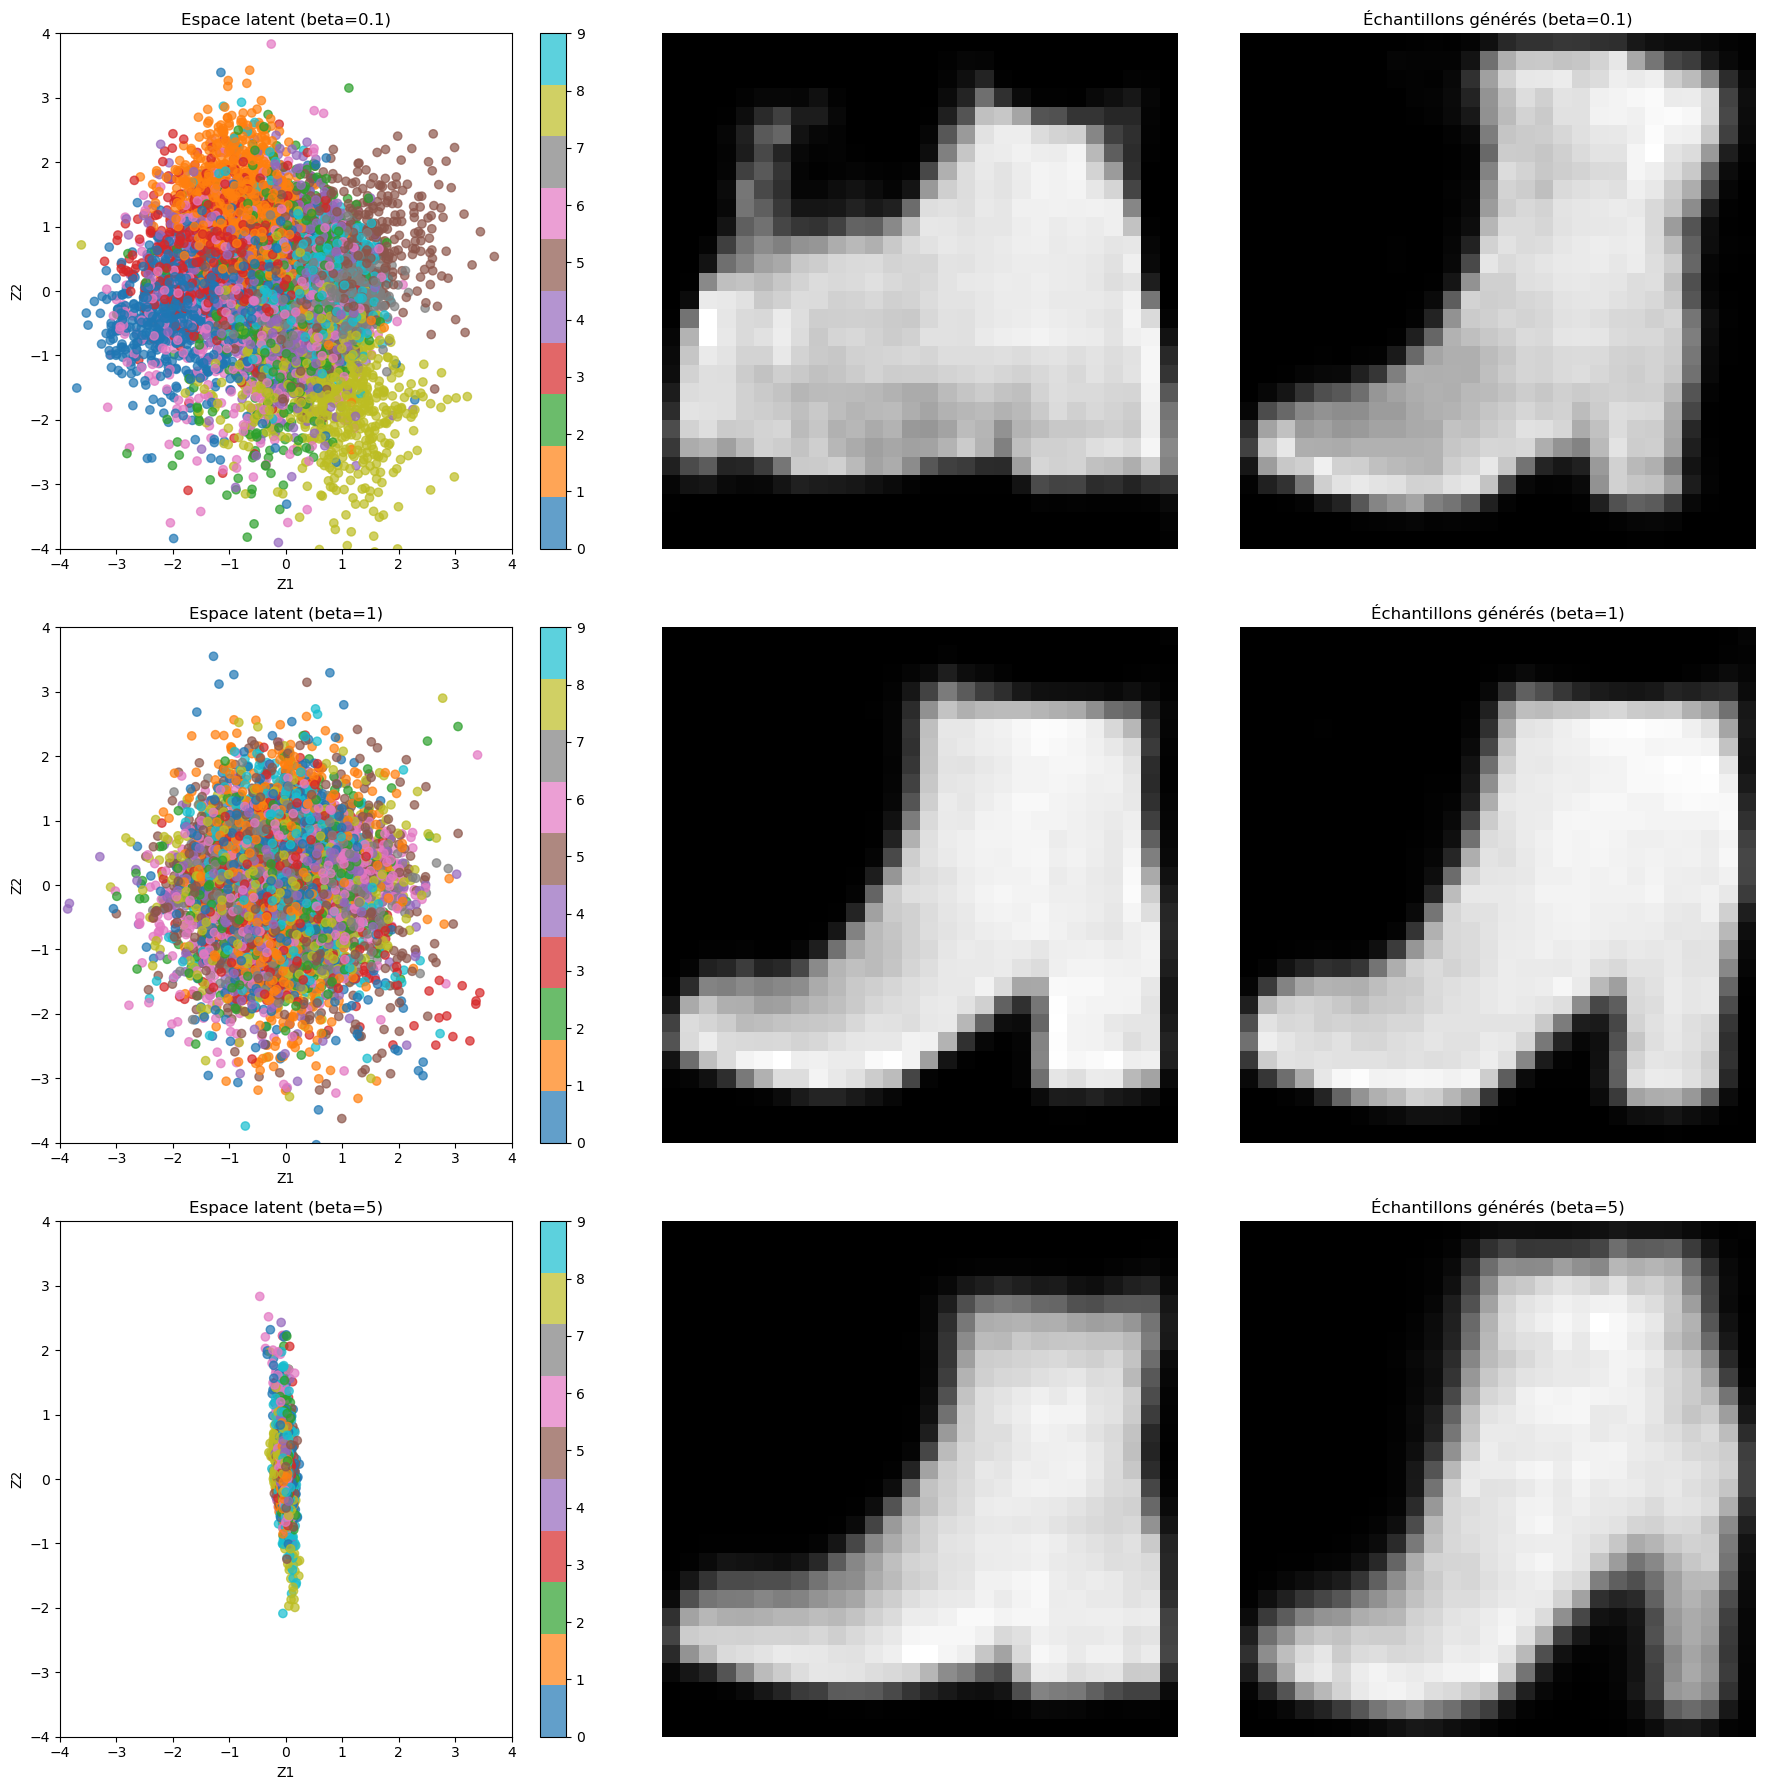

In [41]:
latent_dims = 10
batch_size = 128
num_epochs = 20
learning_rate = 1e-3
beta = [0.1, 1, 5]  #optimisation du beta

def train_and_plot(beta):
    model = ConvCVAE(latent_dims).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)
            one_hot_labels = one_hot(labels, class_size=10).to(device)

            optimizer.zero_grad()

            x_recon, mu, logvar = model(data, one_hot_labels)

            #calcul de la loss
            loss, bce, kld = loss_function(x_recon, data, mu, logvar, beta)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()

        #calcul de la loss par epoch
        average_loss = epoch_loss / len(train_loader.dataset)
        average_bce = bce_loss / len(train_loader.dataset)
        average_kld = kld_loss / len(train_loader.dataset)
        
        print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f}, BCE: {average_bce:.4f}, KLD: {average_kld:.4f}')

    return model

num_classes = 10  
num_samples_per_class = 2

fig, axs = plt.subplots(len(beta), 3, figsize=(18, 6 * len(beta)))  # 3 colonnes : latent space + 2 colonnes pour les échantillons

for idx, b in enumerate(beta):
    print(f'\nTraining VAE with beta = {b}')
    model = train_and_plot(b)
    model.eval()

    # Représentation latente
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        labels = labels.to(device)
        one_hot_labels = one_hot(labels, class_size=10).to(device)

        mu, logvar = model.encode(data, one_hot_labels) 
        z = mu.cpu().numpy()
        labels = labels.cpu().numpy()

        scatter = axs[idx, 0].scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', alpha=0.7)
        axs[idx, 0].set_title(f'Espace latent (beta={b})')
        axs[idx, 0].set_xlabel('Z1')
        axs[idx, 0].set_ylabel('Z2')
        axs[idx, 0].set_xlim(-4, 4)
        axs[idx, 0].set_ylim(-4, 4)
        fig.colorbar(scatter, ax=axs[idx, 0], ticks=range(10))

    # Génération des échantillons
    samples = generate_samples_per_class(model, num_classes, num_samples_per_class)

    for class_label in range(num_classes):
        for sample_idx in range(num_samples_per_class):
            axs[idx, sample_idx + 1].imshow(samples[class_label][sample_idx], cmap="gray")
            axs[idx, sample_idx + 1].axis("off")
        axs[idx, sample_idx + 1].set_title(f'Échantillons générés (beta={b})')

# Ajustement de la mise en page
plt.tight_layout()
plt.show()

**Observations :**
On remarque ici que plus beta est petit plus les différentes classes se distinguent dans la représentation de l'espace latent. Cependant, on ne peut pas mettre beta = 0 car si le facteur KLD de la fonction de perte ne serait pas du tout pris en compte. Avec un beta grand, les données sont gaussiens, ils sont tous regroupés. 

- β élevé : L'espace latent est mieux structuré (plus proche d'une distribution normale) mais les reconstructions peuvent être moins précises, car le modèle est fortement contraint par la régularisation.

- β faible : L'espace late
nt est plus flexible, ce qui permet de meilleures reconstructions, mais l'espace latent peut devenir moins organisé, rendant la génération d'échantillons moins cohérente.

Dans une situation idéale, on voudrait que notre modèle reproduise bien les données mais qu'il génére également correctement de nouvelles données. 
- La qualité de recontruction est gérée par le premier facteur de la fonction de perte : la cross-entropy binaire
- La qualité de génération de données est controlée par le deuxième facteur de la fonction de perte : le terme de divergence de KL

Ainsi, afin d'avoir le meilleur modèle, il faut trouver un compromis entre les deux aspects précedents. 

### Optimisation des paramètres

Ci-dessous nous tentons d'optimiser le modèle CVAE par deux méthodes : avec une grille de paramètres et avec la librairie Optuna

Tout d'abord on met en place la première méthode. Dans notre cas on choisit d'optimiser la variable beta et laa dimension de l'espace latent. Plusieurs choix de valeurs sont données afin que le code établisse des combinaisons de paramètres différents. Plusieurs modèle CVAE sont entrainés avec des combinaisons d'hyper-paramètres différents dans le but de trouver la combinaison la plus optimale.

afficher la loss courbe pour chaque combi

In [42]:
import pandas as pd
import itertools
import random

def train_with_different_params(param_grid, batch_size=128):
    # Générer toutes les combinaisons uniques d'hyperparamètres
    param_combinations = list(itertools.product(
        param_grid['latent_dim'],
        param_grid['learning_rate'],
        param_grid['epochs'],
        param_grid['beta']
    ))
    print(param_combinations)

    # Liste pour stocker les résultats
    results = []

    # Itérer sur chaque combinaison unique
    for latent_dim, learning_rate, epochs, beta in param_combinations:
        params = {
            "latent_dim": latent_dim,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "beta": beta
        }
        print(f"\nTraining with params: {params}")
        
        cvae = ConvCVAE(latent_dim=latent_dim, num_classes=10).to(device)
        optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
        
        for epoch in range(1, epochs + 1):
            cvae.train()
            running_loss = 0.0
            running_mse = 0.0
            
            for data, labels in train_loader:
                data = data.to(device)
                one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)
                
                optimizer.zero_grad()
                recon_batch, mu, logvar = cvae(data, one_hot_labels)
                
                # Compute loss and MSE
                loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
                mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                running_mse += mse
            
            # Average loss and MSE over the dataset
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_mse = running_mse / len(train_loader.dataset)
            
            # Print epoch results
            print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss:.4f}, MSE: {epoch_mse:.4f}")
        
        # Store the results for this hyperparameter combination
        results.append({
            "latent_dim": latent_dim,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "beta": beta,
            "final_loss": epoch_loss,
            "final_mse": epoch_mse
        })

    # Convert results to a DataFrame for better visualization
    results_df = pd.DataFrame(results)
    print("\nSummary of hyperparameter tuning:")
    #print(results_df)
    
    # Optionally save results to a CSV file
    results_df.to_csv("hyperparameter_tuning_results.csv", index=False)
    
    return results_df


In [ ]:
param_grid = {
    'latent_dim': [10, 20, 40],  #2 : résultat pour la loss pas très bons
    'epochs': [15],
    'beta': [0.1, 1, 5, 10],
    'learning_rate' : [1e-3]
}

train_with_different_params(param_grid)

[(10, 0.001, 15, 0.1), (10, 0.001, 15, 1), (10, 0.001, 15, 5), (10, 0.001, 15, 10), (20, 0.001, 15, 0.1), (20, 0.001, 15, 1), (20, 0.001, 15, 5), (20, 0.001, 15, 10), (40, 0.001, 15, 0.1), (40, 0.001, 15, 1), (40, 0.001, 15, 5), (40, 0.001, 15, 10)]

Training with params: {'latent_dim': 10, 'learning_rate': 0.001, 'epochs': 15, 'beta': 0.1}
Epoch 1/15, Loss: 259.3965, MSE: 0.0002
Epoch 2/15, Loss: 227.9057, MSE: 0.0001
Epoch 3/15, Loss: 224.9595, MSE: 0.0001
Epoch 4/15, Loss: 223.3819, MSE: 0.0001
Epoch 5/15, Loss: 222.3961, MSE: 0.0001
Epoch 6/15, Loss: 221.7063, MSE: 0.0001
Epoch 7/15, Loss: 221.0433, MSE: 0.0001
Epoch 8/15, Loss: 220.5472, MSE: 0.0001
Epoch 9/15, Loss: 220.2756, MSE: 0.0001
Epoch 10/15, Loss: 219.9053, MSE: 0.0001
Epoch 11/15, Loss: 219.7520, MSE: 0.0001
Epoch 12/15, Loss: 219.4304, MSE: 0.0001
Epoch 13/15, Loss: 219.1203, MSE: 0.0001
Epoch 14/15, Loss: 218.9405, MSE: 0.0001
Epoch 15/15, Loss: 218.7614, MSE: 0.0001

Training with params: {'latent_dim': 10, 'learning

### Optimisation des hyperparamètres avec la library Optuna

In [ ]:
import torch
import torch.optim as optim
import optuna

def objective(trial):
 
    latent_dim = trial.suggest_categorical('latent_dim', [2, 4, 10, 20])
    beta = trial.suggest_categorical('beta', [1, 5, 10, 15])

    
    cvae = ConvCVAE(latent_dim=latent_dim, num_classes=10).to(device)
    optimizer = optim.Adam(cvae.parameters(), lr=1e-3)
    
    running_loss = 0.0
    running_mse = 0.0
    
    for epoch in range(10): 
        cvae.train()
        for data, labels in train_loader:
            data = data.to(device)
            one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = cvae(data, one_hot_labels)
            
            loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
            mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_mse += mse

  
    avg_loss = running_loss / len(train_loader.dataset)
    avg_mse = running_mse / len(train_loader.dataset)
    return avg_mse


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Meilleurs paramètres
print("\nBest trial:")
print(study.best_trial.params)


### Entrainement du modèle avec les hyperparamètres optimisés

Epoch 1, Training loss: 266.9196,  Training mse: 0.0002
Epoch 2, Training loss: 245.0501,  Training mse: 0.0001
Epoch 3, Training loss: 242.0430,  Training mse: 0.0001
Epoch 4, Training loss: 240.5746,  Training mse: 0.0001
Epoch 5, Training loss: 239.2782,  Training mse: 0.0001
Epoch 6, Training loss: 238.5958,  Training mse: 0.0001
Epoch 7, Training loss: 237.9208,  Training mse: 0.0001
Epoch 8, Training loss: 237.4326,  Training mse: 0.0001
Epoch 9, Training loss: 236.9413,  Training mse: 0.0001
Epoch 10, Training loss: 236.6025,  Training mse: 0.0001
Epoch 11, Training loss: 236.2666,  Training mse: 0.0001
Epoch 12, Training loss: 236.0626,  Training mse: 0.0001
Epoch 13, Training loss: 235.7579,  Training mse: 0.0001
Epoch 14, Training loss: 235.5383,  Training mse: 0.0001
Epoch 15, Training loss: 235.3079,  Training mse: 0.0001
Epoch 16, Training loss: 235.1740,  Training mse: 0.0001
Epoch 17, Training loss: 234.9722,  Training mse: 0.0001
Epoch 18, Training loss: 234.8588,  Trai

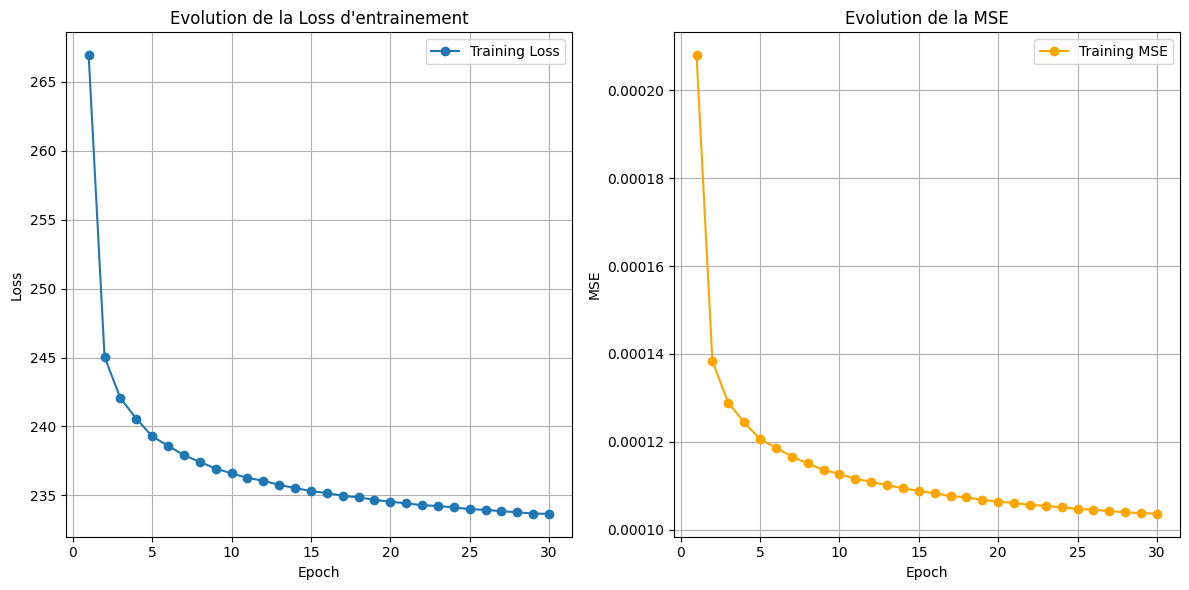

In [12]:
import matplotlib.pyplot as plt
batch_size = 128
latent_dim = 20
learning_rate = 1e-3
epochs = 30
beta = 1

# Modèle et optimizer
cvae2 = ConvCVAE(latent_dim=latent_dim, num_classes=10) 
cvae2.to(device)
optimizer = optim.Adam(cvae2.parameters(), lr=learning_rate)

# Listes pour stocker la loss et la MSE par epoch
loss_history2 = []
mse_history2 = []

for epoch in range(1, epochs + 1):
    cvae2.train()  # Entraînement du modèle
    
    # Initialisation des métriques
    running_loss = 0.0  
    running_mse = 0.0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)  # Conversion des labels

        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae2(data, one_hot_labels)

        # Calcul des métriques
        loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
        mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_mse += mse

    # Calcul de la loss et de la MSE par epoch
    epoch_loss2 = running_loss / len(train_loader.dataset)
    epoch_mse2 = running_mse / len(train_loader.dataset)
    loss_history2.append(epoch_loss2)
    mse_history2.append(epoch_mse2)
    
    print(f'Epoch {epoch}, Training loss: {epoch_loss2:.4f},  Training mse: {epoch_mse2:.4f}')

# Traçage des courbes
plt.figure(figsize=(12, 6))

# Courbe de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), loss_history2, marker='o', label="Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Evolution de la Loss d'entrainement")
plt.grid()
plt.legend()

# Courbe de MSE
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), mse_history2, marker='o', label="Training MSE", color='orange')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Evolution de la MSE')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
cvae2.eval()

with torch.no_grad():
    test_loss2, test_mse2 = 0.0, 0.0
    for data, labels in test_loader:
        data = data.to(device)
        one_hot_labels = one_hot(labels, class_size=10).to(device)
        
        recon_batch, mu, logvar = cvae2(data, one_hot_labels)
        loss, bce, kld = loss_function(recon_batch, data, mu, logvar, beta=beta)
        mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
        
        test_loss2 += loss.item()
        test_mse2 += mse

    test_loss2 /= len(test_loader.dataset)
    test_mse2 /= len(test_loader.dataset)

print(f"Test Loss: {test_loss2:.4f}, Test MSE: {test_mse2:.4f}")


Test Loss: 235.4536, Test MSE: 0.0001


Comparaison des deux modèles : 

In [16]:
#print("Test loss modèle de base : " + str(test_loss))
#print("Test mse modèle de base : " + str(test_mse))
print("---------------------------------------------")
print("Test loss modèle optimisé : " + str(test_loss2))
print("Test mse modèle optimisé : " + str(test_mse2))

---------------------------------------------
Test loss modèle optimisé : 235.45361157226563
Test mse modèle optimisé : 0.00010745188435539603


## Visualisation des résultats

In [18]:
# Récupération d'images et de leur label dans le dataset
random_images, labels = next(iter(test_loader))  

#Conversion des labels
one_hot_labels = one_hot(labels, class_size=10).to(device) 

# Récupération des images reconstruites correspondantes
recons, _, _ = cvae2(random_images.to(device), one_hot_labels)  


random_images = random_images.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()


image_comparison(random_images, recons)


NameError: name 'image_comparison' is not defined

Génération d'échantillons aléatoires

In [19]:
#Générer les échantillons
num_samples_per_class = 3
num_classes = 10

samples = generate_samples_per_class(cvae2, num_classes, num_samples_per_class)


fig, axs = plt.subplots(num_classes, num_samples_per_class, figsize=(10, 15))

for class_label in range(num_classes):
    for sample_idx in range(num_samples_per_class):
        axs[class_label, sample_idx].imshow(samples[class_label][sample_idx], cmap="gray")
        axs[class_label, sample_idx].axis("off")
    
    axs[class_label, 0].text(-0.5, 0.5, f"Classe {class_label}", 
                             rotation=0, size=12, ha="center", va="center",
                             bbox=dict(facecolor='white', alpha=0.8),
                             transform=axs[class_label, 0].transAxes)

plt.tight_layout(h_pad=2)
plt.show()

NameError: name 'generate_samples_per_class' is not defined

Visualisation de l'espace latent résultant de l'optimisation des paramètres 

In [22]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Créer une figure et un axe pour la représentation latente
fig, axs = plt.subplots(1, 1, figsize=(8, 6))  # 1 seul graphique

# Représentation latente
with torch.no_grad():
    test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
    data, labels = next(iter(test_loader))
    data = data.to(device)
    labels = labels.to(device)
    one_hot_labels = one_hot(labels, class_size=10).to(device)

    # Encodage des données dans l'espace latent
    mu, logvar = model.encode(data, one_hot_labels)
    z = mu.cpu().numpy()  # Les coordonnées de l'espace latent
    labels = labels.cpu().numpy()  # Les labels des classes

    # Scatter plot de la représentation latente
    scatter = axs.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axs.set_title('Espace latent du modèle optimisé')
    axs.set_xlabel('Z1')
    axs.set_ylabel('Z2')
    axs.set_xlim(-3, 3)
    axs.set_ylim(-3, 3)
    fig.colorbar(scatter, ax=axs, ticks=range(10))

# Ajustement de la mise en page et affichage
plt.tight_layout()
plt.show()


NameError: name 'axs' is not defined

### Génération vs Reconstruction

beta grand : grande influence du facteur de régularisation KL donc représentation gaussienne dans l'espace latent et bonne qualité de génération de données

beta petit : pas de régularisation donc mauvaise qualité de génération de données, optimisation de la reconstruction d'image 
    

## Conclusion

L'optimisation des hyperparamètres d'un modèle Convolutionnel Variationel Auto-Encodeur dépend de l'objectif final de l'utilisateur. En effet, pour optimiser un CVAE il faut trouver un bon compromis entre la qualité de reconstruction des données ainsi que la qualité de représentation dans l'espace latent.

Nous avons vu que pour assurer une bonne représentation des données dans l'espace latent, il fallait que le facteur beta soit important pour ainsi donner du poids au facteur de KL dans la loss, qui gère la régularisation des données dans l'espace latent. Cependant avec un beta élevé, la reconstruction des données n'est pas bonne. 

Avec un beta nul, le modèle serait optimisé de telle sorte à avoir la plus faible erreur de reconstruction, portée par le premier terme de la fonction de perte.

# 8. Références

- Définition de VAE et CVAE : https://ijdykeman.github.io/ml/2016/12/21/cvae.html
ou https://deepgram.com/ai-glossary/conditional-variational-autoencoders
- Choix des couches du modèle :  https://inside-machinelearning.com/cnn-couche-de-convolution/
- Explication sur les termes de la fonction de perte : https://medium.com/@mrthinger/kl-divergence-vs-cross-entropy-exploring-the-differences-and-use-cases-3f3dee58c452